**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [6]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [7]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [8]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [9]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ann` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [10]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# From Biological to Artificial Neurons
## The Perceptron

In [11]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [7]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [8]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

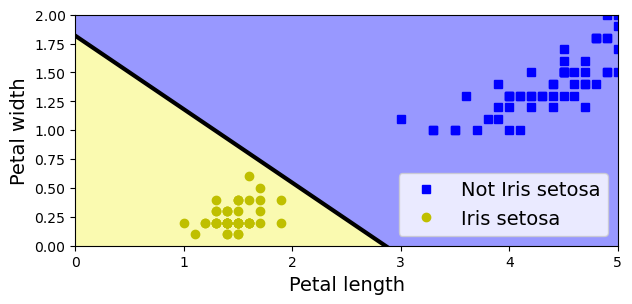

In [12]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Activation functions**

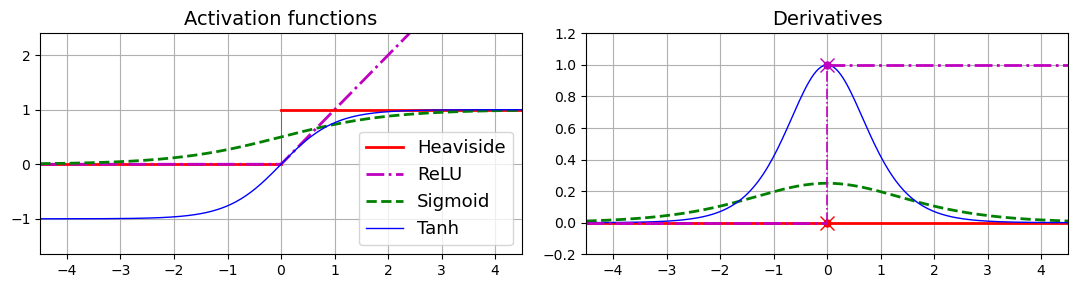

In [10]:
# extra code – this cell generates and saves Figure 10–8

from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## Regression MLPs

**Warning**: In recent versions of Scikit-Learn, you must use `root_mean_squared_error()` to compute the RMSE, instead of `mean_squared_error(labels, predictions, squared=False)`. The following `try`/`except` block tries to import `root_mean_squared_error`, and if it fails it just defines it.

In [11]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

In [12]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42) # Separación Train / Test - > Test es definitivo
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42) #Separación Train/Valid

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42) # Establece 3 capas ocultas con 50 neuronas cada una
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)

In [13]:
rmse

0.505332665796858

## Classification MLPs

In [14]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [13]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()# cargamos el dataset
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000] # separamos train  de train full para coger 5000 de validación
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [16]:
X_train.shape

(55000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [17]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

In [18]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

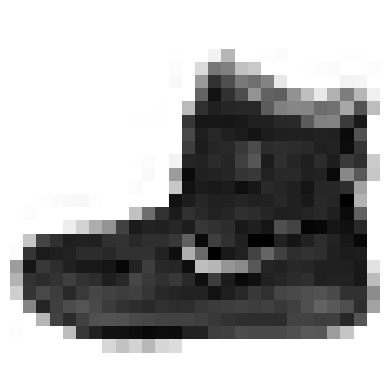

In [19]:
# extra code

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [20]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [21]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is an ankle boot:

In [22]:
class_names[y_train[0]]

'Ankle boot'

Let's take a look at a sample of the images in the dataset:

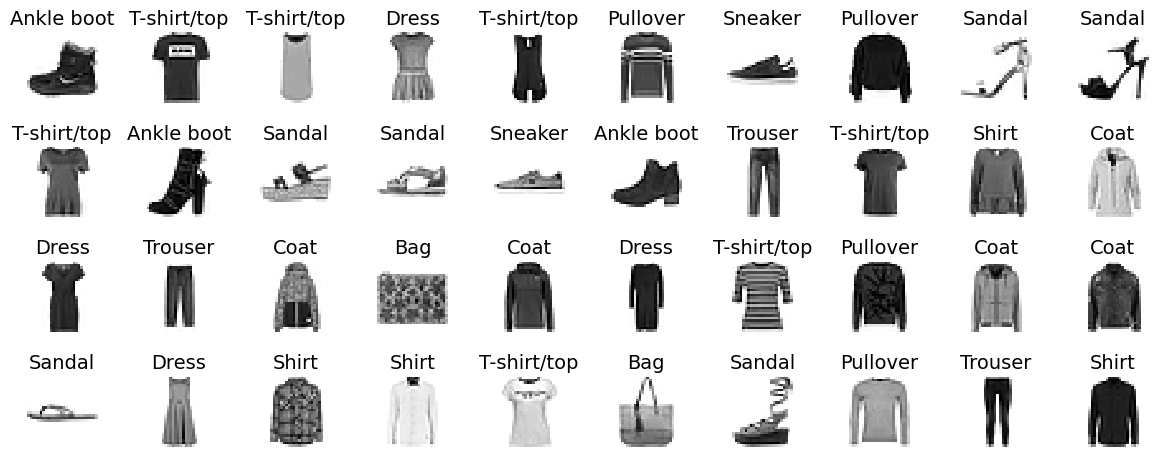

In [23]:
# extra code – this cell generates and saves Figure 10–10

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest") #binary-> escala de blancos y negros, interpolation="nearest" -> no suaviza la imagen-> pixelada
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

###  Creación del modelo con la API Secuencial / Creating the model using the Sequential API

In [24]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))# Keras necesita conocer la forma  de las entradas para poder determinar la la forma de la matriz de pesos de conexión de la 1ª capa oculta
model.add(tf.keras.layers.Flatten()) # capa de aplanado-> convierte cada imagen de entrada en 1D
model.add(tf.keras.layers.Dense(300, activation="relu")) # Añadimos una capa Dense oculta con 300 neuronas. Función de activación relu
model.add(tf.keras.layers.Dense(100, activation="relu")) # Añadimos otra capa Dense oculta con 100 neuronas. Función de activación relu
model.add(tf.keras.layers.Dense(10, activation="softmax")) # Añadimos una capa de salida Dense 10 neuronas (una por clase). Función de activación softmax

In [25]:
# extra code – clear the session to reset the name counters
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


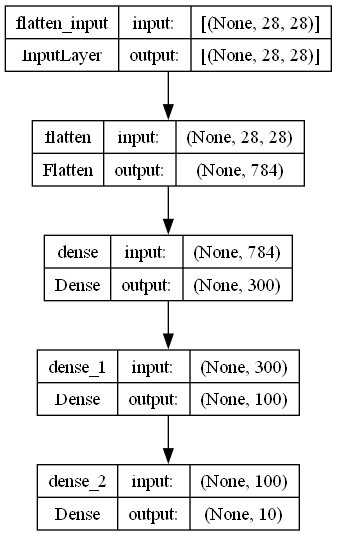

In [27]:
# extra code – another way to display the model's architecture
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True) #"my_fashion_mnist_model.png" -> es el nombre que le doy  a la imagen .png que generará

In [28]:
model.layers # para conseguir fácilmente una lista de capas del modelo

In [29]:
hidden1 = model.layers[1] #obtiene la segunda capa del modelo (índice 1, porque empieza en 0).
hidden1.name #muestra el nombre que Keras le ha asignado

'dense'

In [30]:
model.get_layer('dense') is hidden1 # ¿La capa cuyo nombre es ‘dense’ es exactamente la misma que la capa hidden1?

True

In [31]:
# Para acceder a los parámetros de las capas
weights, biases = hidden1.get_weights()
weights

array([[-0.06508884,  0.06541809, -0.07330658, ..., -0.00768351,
        -0.05970652,  0.06430328],
       [ 0.01725106, -0.05158627,  0.02724114, ...,  0.04138965,
         0.04893485,  0.03098312],
       [-0.06774021,  0.05912738,  0.02896343, ...,  0.03179276,
         0.05359519, -0.04789189],
       ...,
       [ 0.03828943, -0.00573114, -0.00821011, ..., -0.03276822,
         0.07410498,  0.07235315],
       [-0.00102975,  0.00166313,  0.07291918, ..., -0.02488218,
        -0.05821869, -0.02959   ],
       [ 0.03729877,  0.06077354, -0.01997094, ...,  0.05153647,
         0.05182312,  0.06339842]], dtype=float32)

In [32]:
weights.shape

(784, 300)

In [33]:
biases # el sesgo empieza en cero. i lo inicias en 0, no introduces ninguna preferencia inicial en ninguna neurona. El aprendizaje se encargará de ir ajustándolos.

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
biases.shape 

(300,)

### Compilación del modelo

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
# Loss -> Cómo mide el el error
# Optimizer -> Cómo ajusta los pesos
# metrics -> Qué métrica mostrar mientras se entreba

This is equivalent to:

In [36]:
# extra code – this cell is equivalent to the previous cell
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [37]:
# extra code – shows how to convert class ids to one-hot vectors
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Note: it's important to set `num_classes` when the number of classes is greater than the maximum class id in the sample.

In [38]:
# extra code – shows how to convert one-hot vectors to class ids
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0], dtype=int64)

### Training and evaluating the model

In [39]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


1719/1719 [==============================] - 5s 3ms/step - loss: 0.7151 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.5061 - val_sparse_categorical_accuracy: 0.8284
Epoch 2/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4888 - sparse_categorical_accuracy: 0.8286 - val_loss: 0.4671 - val_sparse_categorical_accuracy: 0.8310
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4425 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.4276 - val_sparse_categorical_accuracy: 0.8484
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4166 - sparse_categorical_accuracy: 0.8547 - val_loss: 0.3973 - val_sparse_categorical_accuracy: 0.8616
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3950 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.3903 - val_sparse_categorical_accuracy: 0.8614
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3780 - spa

Podría haber hecho:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.1)
de esta manera reserva el 10% de x_train e y_train para validación. No haría falta la separación previa

In [40]:
history.params # te dice cómo entrenó el modelo (épocas, pasos, verbose)

{'verbose': 1, 'epochs': 30, 'steps': 1719}

Interpretación de cada parámetro
1. 'verbose': 1

Indica el nivel de detalle del entrenamiento:

0 → no muestra nada

1 → barra de progreso (lo que estás viendo)

2 → una línea por época

Tú estás usando verbose=1 (por defecto).


2. 'epochs': 30

Has entrenado durante 30 épocas.

Una “epoch” significa que la red ha visto todas las imágenes de entrenamiento una vez.
3. 'steps': 1719

Esto significa:

“para cada época, hago 1719 pasos (batches).”
Los steps dependen del tamaño del batch:
steps = tamaño_del_dataset / batch_size



In [41]:
history2 = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2214 - sparse_categorical_accuracy: 0.9204 - val_loss: 0.3348 - val_sparse_categorical_accuracy: 0.8788
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2187 - sparse_categorical_accuracy: 0.9210 - val_loss: 0.3130 - val_sparse_categorical_accuracy: 0.8858
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9226 - val_loss: 0.3118 - val_sparse_categorical_accuracy: 0.8858
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2121 - sparse_categorical_accuracy: 0.9241 - val_loss: 0.3075 - val_sparse_categorical_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2077 - sparse_categorical_accuracy: 0.9253 - val_loss: 0.3056 - val_sparse_categorical_accuracy: 0.8906
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2044 - spars

In [42]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [43]:
# sumo las historias
full_history = {}
for key in history.history.keys():
    full_history[key] = history.history[key] + history2.history[key]


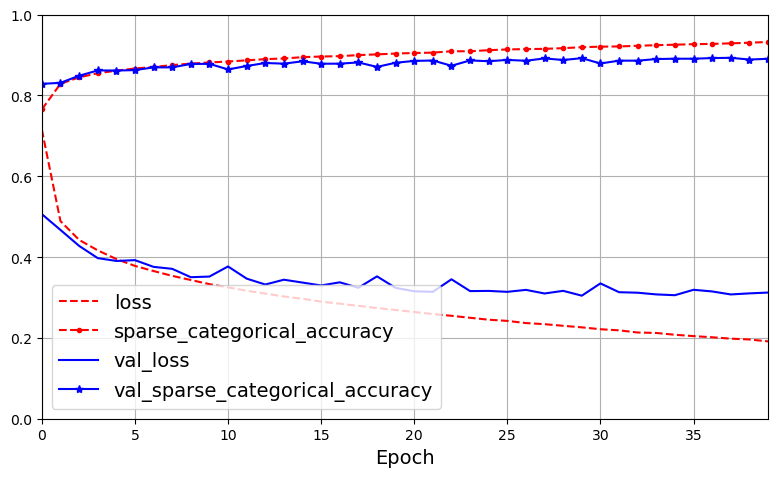

In [44]:
# Para obtener las curvas de aprendizaje

import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(full_history).plot(
    figsize=(8, 5), xlim=[0, 39], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
save_fig("keras_learning_curves_plot")  # extra code
plt.show()

Si ves que el modelo no ha convergido (puede seguir mejorando) -> Puedes seguir entrenando el mismo modelo desde donde lo dejaste

si hice esto:
history1 = model.fit(X_train, y_train, epochs=30,
                     validation_data=(X_valid, y_valid))

Y veo en la gráfica que la pérdida todavía baja → quiero seguir otras 10 épocas.
history2 = model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

Eso es todo.
No resetea los pesos.
Continúa exactamente donde se quedó tras las primeras 30 épocas.

Esto es así porque los pesos del modelo ya están en memoria modificados por el entrenamiento anterior.

model.fit(...) siempre entrena a partir del estado actual del modelo, a menos que llames a:

model = ... (construyes uno nuevo)

model.set_weights(...)

o cargues pesos desde un archivo


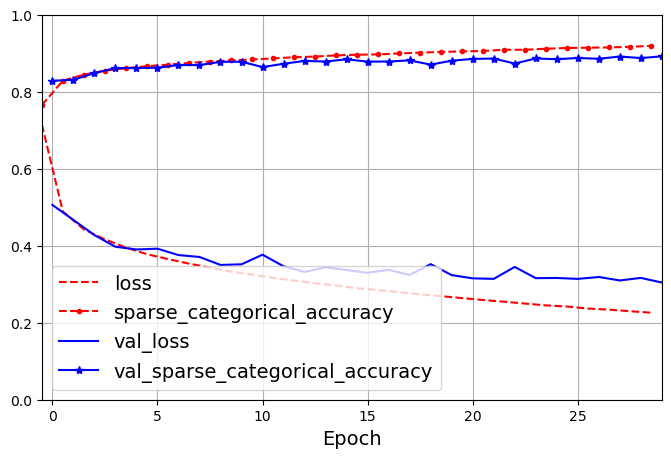

In [45]:
# extra code – shows how to shift the training curve by -1/2 epoch
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Epoch")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [46]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3291 - sparse_categorical_accuracy: 0.8844


[0.3291096091270447, 0.8844000101089478]

### Using the model to make predictions

In [47]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 137ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [48]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

In [49]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [50]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

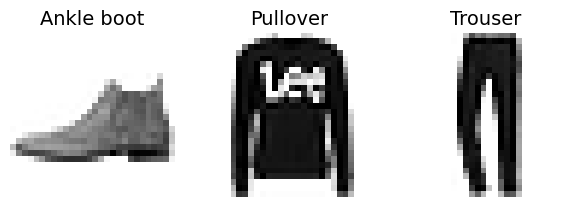

In [51]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset (the original one, not the modified one as in chapter 2):

In [52]:
# extra code – load and split the California housing dataset, like earlier
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [53]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:]) #En regresión hay que normalizar primero (como StandarScaler en Scikit Learn). Tb podría normalizar con scikit learn (StandardScaler)
# en input_shape keras pide la forma de una muestra, no de todo el conjunto
# si hago X_train.shape -> (16512,8) una tupla de dos elementos pero sólo necesito el 2º elemento de la tupla. Como queremos que siga siendo tupla(2D -> (,8) y no un número enetro ,1D -> 8 ponemos X_train.shape[1:] en lugar de  X_train.shape[1]
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"]) # función de pérdidad -> error cuadrático medio
norm_layer.adapt(X_train) # adapto el X_train a la normalización
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test) # evaluate pasa el conjutno de test por el modelo y extrae las metricas definidas en compile:
# el loss -> mse
# la métrica -> RMSE
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 0.8674 - root_mean_squared_error: 0.9314 - val_loss: 0.6367 - val_root_mean_squared_error: 0.7980
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3873 - root_mean_squared_error: 0.6224 - val_loss: 0.4531 - val_root_mean_squared_error: 0.6731
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3610 - root_mean_squared_error: 0.6009 - val_loss: 0.4282 - val_root_mean_squared_error: 0.6544
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3487 - root_mean_squared_error: 0.5905 - val_loss: 0.6214 - val_root_mean_squared_error: 0.7883
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3348 - root_mean_squared_error: 0.5786 - val_loss: 0.8227 - val_root_mean_squared_error: 0.9070
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3286 - root_mean_squared_error: 0.5733 - val_loss: 0.3845 - val_

In [54]:
rmse_test

0.5269220471382141

In [55]:
y_pred

array([[0.41689345],
       [1.010465  ],
       [5.1994934 ]], dtype=float32)

## Creación de modelos complejos con la API Funcional /Building Complex Models Using the Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

In [56]:
# extra code – reset the name counters and make the code reproducible
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [57]:
# Este primer bloque genera las capas que necesitamos
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

#En este segundo bloque usamos las capas como funciones (por eso es una "API funcional") para ir de la entrada a la salida
input_ = tf.keras.layers.Input(shape=X_train.shape[1:]) # se pone "input_" porque la palabra "input" está reservada en python
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

# Objeto Model donde se señala la entrada  y la salida
model = tf.keras.Model(inputs=[input_], outputs=[output])

In [58]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 normalization (Normalizati  (None, 8)                    17        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 dense (Dense)               (None, 30)                   270       ['normalization[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 30)                   930       ['dense[0][0]']           

In [59]:
# y seguimos como antes:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"]) # Compilamos
normalization_layer.adapt(X_train) # adaptamos la normailzación a nuestra entrada
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid)) # Ajustamos el modelo
mse_test = model.evaluate(X_test, y_test) # Lo evaluamos
y_pred = model.predict(X_new) # predecimos

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.4936 - root_mean_squared_error: 1.2221 - val_loss: 2.1725 - val_root_mean_squared_error: 1.4740
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5374 - root_mean_squared_error: 0.7330 - val_loss: 0.7088 - val_root_mean_squared_error: 0.8419
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4331 - root_mean_squared_error: 0.6581 - val_loss: 0.4939 - val_root_mean_squared_error: 0.7028
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3945 - root_mean_squared_error: 0.6281 - val_loss: 0.3730 - val_root_mean_squared_error: 0.6107
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3751 - root_mean_squared_error: 0.6124 - val_loss: 0.3618 - val_root_mean_squared_error: 0.6015
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3594 - root_mean_squared_error: 0.5995 - val_loss: 0.4113 - val_

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [60]:
tf.random.set_seed(42)  # extra code

In [61]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4 -> Por qué shape=[5] y no shape=5? Porque Keras siempre espera una tupla o LISTA para describir la forma de la entrada, no un número suelto
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
# Normalizo ambas capas: entrada ancha y entrada profunda
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
# monto capas por el lado de la entrada profunda
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
# concateno ambos canales
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
# genero la salida a partir del concat
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [62]:
# ahora hacemos lo de siempre, pero en la entrada metemos 2 matrices: X_train_wide y X_train_deep

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

#X_train_wide y X_train_deep comparten las columnas 2,3,4 porque la parte wide analiza las caracteristicas simples buscando patrones simples y la parte deep analiza esas mismas columnas más otras 3 (5-7) analizando relaciones complejas y no lineales

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:] 
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3] #Selecciona las 3 primeras filas del conjunto de test para hacer predicciones nuevas.

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid)) # El modelo tiene dos entradas, pero una sola salida (un valor a predecir) -> no debe haber y_valid_wide ni y_valid_deep.
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.4833 - root_mean_squared_error: 1.2179 - val_loss: 0.6618 - val_root_mean_squared_error: 0.8135
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5584 - root_mean_squared_error: 0.7473 - val_loss: 0.8757 - val_root_mean_squared_error: 0.9358
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4709 - root_mean_squared_error: 0.6862 - val_loss: 0.4148 - val_root_mean_squared_error: 0.6440
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4215 - root_mean_squared_error: 0.6492 - val_loss: 0.4210 - val_root_mean_squared_error: 0.6488
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3956 - root_mean_squared_error: 0.6290 - val_loss: 0.6605 - val_root_mean_squared_error: 0.8127
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.3758 - root_mean_squared_error: 0.6130 - val_loss: 1.3048 - val_

Adding an auxiliary output for regularization:

In [63]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [64]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

**Warning**: in recent versions, Keras requires one metric per output, so I replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"]) # nuevas versionae una métrica por salida, aquí solo una. Ver nota warning)

In [66]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20, # hay que suministrar etiquetas para cada salida. En este caso son las mismas
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 1.4732 - dense_2_loss: 1.3833 - dense_3_loss: 2.2825 - dense_2_root_mean_squared_error: 1.1761 - dense_3_root_mean_squared_error: 1.5108 - val_loss: 1.8076 - val_dense_2_loss: 1.6359 - val_dense_3_loss: 3.3530 - val_dense_2_root_mean_squared_error: 1.2790 - val_dense_3_root_mean_squared_error: 1.8311
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5261 - dense_2_loss: 0.4993 - dense_3_loss: 0.7671 - dense_2_root_mean_squared_error: 0.7066 - dense_3_root_mean_squared_error: 0.8759 - val_loss: 0.8795 - val_dense_2_loss: 0.7956 - val_dense_3_loss: 1.6350 - val_dense_2_root_mean_squared_error: 0.8920 - val_dense_3_root_mean_squared_error: 1.2787
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4550 - dense_2_loss: 0.4371 - dense_3_loss: 0.6162 - dense_2_root_mean_squared_error: 0.6611 - dense_3_root_mean_squared_error: 0.7850 - val_loss: 0.5417 - val_dense_2_loss

**Warning**: in recent TF version, `evaluate()` also returns the main metric and the aux metric. To ensure the code works in both old and new versions, we only look at the first 3 elements of `eval_results` (i.e., just the losses):

In [67]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss = eval_results[:3]

# Al evaluar el modelo, keras devuelve:
    #1) suma ponderada de las pérdidas -> weighted_sum_of_losses
    #2) todas las pérdidas individuales -> main_loss, aux_loss
    #3) todas las méttricas insividuales ->main_rmse, aux_rmse (en este caso, no se ha incluido)

162/162 [==============================] - 0s 1ms/step - loss: 0.3336 - dense_2_loss: 0.3272 - dense_3_loss: 0.3909 - dense_2_root_mean_squared_error: 0.5721 - dense_3_root_mean_squared_error: 0.6252


In [68]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 [==============================] - 0s 88ms/step


In [69]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple)) # el método .predict() devuelve una tupla, pero no tiene argumento return_dict para obtener diccionario en su lugar -> creamos uno usandomodel.output_names

1/1 [==============================] - 0s 18ms/step


In [70]:
y_pred

{'dense_2': array([[0.4018854],
        [1.171758 ],
        [3.4454608]], dtype=float32),
 'dense_3': array([[0.5174835],
        [1.0037099],
        [3.2303796]], dtype=float32)}

## Utilización de la API de subclasificación para crear modelos dinámicos _ Using the Subclassing API to Build Dynamic Models


In [71]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

**Warning**: as explained above, Keras now requires one loss and one metric per output, so I replaced `loss="mse"` with `loss=["mse", "mse"]` and I also replaced `metrics=["RootMeanSquaredError"]` with `metrics=["RootMeanSquaredError", "RootMeanSquaredError"]` in the code below.

In [72]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 1.6616 - output_1_loss: 1.6079 - output_2_loss: 2.1444 - output_1_root_mean_squared_error: 1.2680 - output_2_root_mean_squared_error: 1.4644 - val_loss: 0.8954 - val_output_1_loss: 0.6908 - val_output_2_loss: 2.7365 - val_output_1_root_mean_squared_error: 0.8312 - val_output_2_root_mean_squared_error: 1.6542
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5706 - output_1_loss: 0.5534 - output_2_loss: 0.7245 - output_1_root_mean_squared_error: 0.7439 - output_2_root_mean_squared_error: 0.8512 - val_loss: 1.0134 - val_output_1_loss: 0.9693 - val_output_2_loss: 1.4096 - val_output_1_root_mean_squared_error: 0.9845 - val_output_2_root_mean_squared_error: 1.1873
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4894 - output_1_loss: 0.4756 - output_2_loss: 0.6135 - output_1_root_mean_squared_error: 0.6897 - output_2_root_mean_squared_error: 0.7832 - val_loss: 0.438

## Saving and Restoring a Model

**Warning**: Keras now recommends using the `.keras` format to save models, and the `h5` format for weights. Therefore I have updated the code in this section to first show what you need to change if you still want to use TensorFlow's `SavedModel` format, and then how you can use the recommended formats.

In [73]:
# extra code – delete the directory, in case it already exists

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

**Warning**: Keras's `model.save()` method no longer supports TensorFlow's `SavedModel` format. However, you can still export models to the `SavedModel` format using `model.export()` like this:

In [74]:
model.export("my_keras_model")

INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


Saved artifact at 'my_keras_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Tuple[TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_1'), TensorSpec(shape=(None, 6), dtype=tf.float32, name='input_2')]
Output Type:
  Tuple[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  1654725760752: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  1654745089648: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  1654745088592: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  1654744422304: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  1654744424064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1654744421952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1654744429520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1654744418608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1654744419136: TensorSpec(shape=(), dtyp

In [75]:
# forma antigua
model.save("my_keras_model", save_format="tf")
model = tf.keras.models.load_model("my_keras_model")


INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


In [76]:
# extra code – show the contents of the my_keras_model/ directory
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model\assets
my_keras_model\fingerprint.pb
my_keras_model\keras_metadata.pb
my_keras_model\saved_model.pb
my_keras_model\variables
my_keras_model\variables\variables.data-00000-of-00001
my_keras_model\variables\variables.index


**Warning**: In Keras 3, it is no longer possible to load a TensorFlow `SavedModel` as a Keras model. However, you can load a `SavedModel` as a `tf.keras.layers.TFSMLayer` layer, but be aware that this layer can only be used for inference: no training.

In [77]:
tfsm_layer = tf.keras.layers.TFSMLayer("my_keras_model")
y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))

AttributeError: module 'keras.api._v2.keras.layers' has no attribute 'TFSMLayer'

**Warning**: Keras now requires the saved weights to have the `.weights.h5` extension. There are no longer saved using the `SavedModel` format.

In [78]:
model.save_weights("my_weights.weights.h5")

In [79]:
model.load_weights("my_weights.weights.h5")

To save a model using the `.keras` format, simply use `model.save()`:

In [80]:
model.save("my_model.keras")

To load a `.keras` model, use the `tf.keras.models.load_model()` function. If the model uses any custom object, you must pass them to the function via the `custom_objects` argument:

In [81]:
loaded_model = tf.keras.models.load_model(
    "my_model.keras",
    custom_objects={"WideAndDeepModel": WideAndDeepModel}
)

ValueError: Layer 'normalization_4' expected 0 variables, but received 3 variables during loading. Expected: []

🟦 1. ANTES (Keras 2 / TensorFlow 2.x)
🔵 (A) Guardar modelo completo
model.save("my_keras_model", save_format="tf")


Esto guardaba:

arquitectura

pesos

configuración de compilación

grafo de TF

assets

Y lo recuperabas con:

model = tf.keras.models.load_model("my_keras_model")


🔹 Esto NO guardaba solo los pesos. Guardaba TODO.

🔵 (B) Guardar solo pesos
model.save_weights("weights.h5")
model.load_weights("weights.h5")


Igual que hoy.

🔵 (C) Guardar SavedModel para producción

Era lo mismo que (A), porque save_format="tf" producía un SavedModel.

🟩 2. AHORA (Keras 3 / TensorFlow 2.16+)
🟢 (A) Guardar modelo completo (reemplazo moderno de model.save antiguo)
model.save("my_model.keras")
model = keras.models.load_model("my_model.keras")


Este .keras contiene:

arquitectura

pesos

configuración de compilación

estado del optimizador

🔹 Esto es EXACTAMENTE lo que antes era model.save(..., save_format="tf").
🔹 NO tienes que guardar pesos por separado.

👉 En el 99% de casos, esto es lo que debes usar.

🟢 (B) Guardar solo pesos (idéntico a antes)
model.save_weights("weights.h5")
model.load_weights("weights.h5")


Esto no ha cambiado entre Keras 2 y Keras 3.

🟢 (C) Exportar SavedModel para producción

Ahora se hace así:

model.export("my_keras_model")


No con model.save(...).

Y para reutilizarlo en Keras 3 puedes:

O bien usar TFSMLayer (si tu TF lo soporta)

O bien usar tf.saved_model.load(...) directamente

Esto es solo para producción/serving, NO para continuar entrenando.

## Using Callbacks

In [82]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # extra code

**Warning**: as explained earlier, Keras now requires the checkpoint files to have a `.weights.h5` extension:

In [83]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 2s 3ms/step - loss: 0.3611 - output_1_loss: 0.3531 - output_2_loss: 0.4333 - output_1_root_mean_squared_error: 0.5942 - output_2_root_mean_squared_error: 0.6583 - val_loss: 0.3284 - val_output_1_loss: 0.3152 - val_output_2_loss: 0.4470 - val_output_1_root_mean_squared_error: 0.5614 - val_output_2_root_mean_squared_error: 0.6686
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3505 - output_1_loss: 0.3428 - output_2_loss: 0.4196 - output_1_root_mean_squared_error: 0.5855 - output_2_root_mean_squared_error: 0.6478 - val_loss: 0.4380 - val_output_1_loss: 0.4153 - val_output_2_loss: 0.6423 - val_output_1_root_mean_squared_error: 0.6444 - val_output_2_root_mean_squared_error: 0.8015
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.3433 - output_1_loss: 0.3357 - output_2_loss: 0.4113 - output_1_root_mean_squared_error: 0.5794 - output_2_root_mean_squared_error: 0.6413 - val_loss: 0.330

In [84]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True) # Patience -> número de repeticiones antes de parar el entrenamiento
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb]) # Puedo combinar ambas callbacks

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3318 - output_1_loss: 0.3251 - output_2_loss: 0.3924 - output_1_root_mean_squared_error: 0.5702 - output_2_root_mean_squared_error: 0.6265 - val_loss: 0.4090 - val_output_1_loss: 0.4008 - val_output_2_loss: 0.4824 - val_output_1_root_mean_squared_error: 0.6331 - val_output_2_root_mean_squared_error: 0.6945
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3353 - output_1_loss: 0.3290 - output_2_loss: 0.3918 - output_1_root_mean_squared_error: 0.5736 - output_2_root_mean_squared_error: 0.6260 - val_loss: 0.3229 - val_output_1_loss: 0.3155 - val_output_2_loss: 0.3901 - val_output_1_root_mean_squared_error: 0.5617 - val_output_2_root_mean_squared_error: 0.6246
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3259 - output_1_loss: 0.3196 - output_2_loss: 0.3825 - output_1_root_mean_squared_error: 0.5654 - output_2_root_mean_squared_error: 0.6184 - val_loss: 0.

In [85]:
# Retrolllanada / Callback personalizada

class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

# Mide proporción entre pérdida de validación y pérdida de entrenamiento
# Importante yo defino qué hace al finalizar cada epoch pero keras sabe que la función on_epoch_end se ejecuta después de cada época

Porque Keras ya tiene programado internamente:

llamar on_epoch_begin() al principio de cada época

llamar on_epoch_end() al final

llamar on_train_batch_begin() al empezar cada batch

llamar on_train_batch_end() al terminar cada batch

etc.

In [86]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.18
Epoch=1, val/train=0.98
Epoch=2, val/train=1.64
Epoch=3, val/train=1.88
Epoch=4, val/train=3.16
Epoch=5, val/train=2.10
Epoch=6, val/train=2.17
Epoch=7, val/train=1.29
Epoch=8, val/train=1.87
Epoch=9, val/train=1.05


## Using TensorBoard for Visualization

TensorBoard is preinstalled on Colab, but not the `tensorboard-plugin-profile`, so let's install it:

In [87]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [88]:
shutil.rmtree("my_logs", ignore_errors=True)

In [89]:
# pip install tensorboard

In [90]:
# Necesitamos el plugin para visualizar los datos de creación  de perfiles
# pip install tensorboard-plugin-profile

In [91]:
# Conviene apuntar el servidor de Tensorflow a un directorio de registro raíz y configurar el programa para que escriba en un subdirectorio diferente cada vez que se ejecute
# my_logs -> directorio raíz y definimos función para que genere ruta del subdirectorio basándose en la fecha y hora actuales
from pathlib import Path # para trabajar con rutas de carpetas de forma cómoda.
from time import strftime # para generar cadenas con la fecha/hora.

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S") #Genera un string basado en la fecha y la hora actuale

run_logdir = get_run_logdir()

El código de arriba sirve para que cada vez que entrenes tu modelo se cree un subdirectorio nuevo dentro de my_logs/ con un nombre único basado en la fecha y hora.

TensorBoard necesita directorios distintos para:

no mezclar las curvas de diferentes ejecuciones (runs),

poder comparar entrenamientos entre sí,

mantener un historial limpio.

In [92]:
# extra code – builds the first regression model we used earlier
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

In [93]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200)) # perfilará la red entrre los lotes 100 y 200 durante la primera repetición
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 1.8038 - root_mean_squared_error: 1.3431 - val_loss: 1.2049 - val_root_mean_squared_error: 1.0977
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7709 - root_mean_squared_error: 0.8780 - val_loss: 0.7305 - val_root_mean_squared_error: 0.8547
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7019 - root_mean_squared_error: 0.8378 - val_loss: 0.6763 - val_root_mean_squared_error: 0.8224
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6619 - root_mean_squared_error: 0.8135 - val_loss: 0.6422 - val_root_mean_squared_error: 0.8014
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6303 - root_mean_squared_error: 0.7939 - val_loss: 0.6092 - val_root_mean_squared_error: 0.7805
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6015 - root_mean_squared_error: 0.7756 - val_loss: 0.5854 - val_

In [94]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2025_12_01_17_30_37
    plugins
      profile
        2025_12_01_16_30_38
          KITIPALI.xplane.pb
    train
      events.out.tfevents.1764606637.KITIPALI.36624.0.v2
    validation
      events.out.tfevents.1764606638.KITIPALI.36624.1.v2


Let's load the `tensorboard` Jupyter extension and start the TensorBoard server: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**Note**: if you prefer to access TensorBoard in a separate tab, click the "localhost:6006" link below:

In [ ]:
# extra code

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

You can use also visualize histograms, images, text, and even listen to audio using TensorBoard:

In [95]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

**Note**: it used to be possible to easily share your TensorBoard logs with the world by uploading them to https://tensorboard.dev/. Sadly, this service will shut down in December 2023, so I have removed the corresponding code examples from this notebook.

When you stop this Jupyter kernel (a.k.a. Runtime), it will automatically stop the TensorBoard server as well. Another way to stop the TensorBoard server is to kill it, if you are running on Linux or MacOSX. First, you need to find its process ID:

In [96]:
# extra code – lists all running TensorBoard server instances

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6007: logdir my_fashion_mnisthyperbandtensorboard (started 0:22:04 ago; pid 16120)
  - port 6006: logdir ./my_logs (started 6:55:53 ago; pid 34504)


Next you can use the following command on Linux or MacOSX, replacing `<pid>` with the pid listed above:

    !kill <pid>

On Windows:

    !taskkill /F /PID <pid>

#  Ajuste de los hiperparámetros de una red neuronal - Fine-Tuning Neural Network Hyperparameters

In this section we'll use the Fashion MNIST dataset again:

In [2]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6007: logdir my_fashion_mnisthyperbandtensorboard (started 0:29:07 ago; pid 16120)
  - port 6006: logdir ./my_logs (started 7:02:56 ago; pid 34504)


In [4]:
!taskkill /F /PID 34504

ERROR: no se encontró el proceso "34504".


In [97]:
# pip install keras-tuner


In [14]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [100]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [16]:
import keras_tuner as kt

# hp (HyperParameters) es un objeto que entrega Keras Tuner automáticamente


def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden): # repite n_hidden veces
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax")) # La capa de salida es de 10 neuronas porque  dará una probabilidad por cada clase (números de 0-9)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [17]:
# para hacer una búsqueda aleatoria básica
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid)) 
#En directory y en project_name pongo el nombre  que quiera

Trial 5 Complete [00h 00m 36s]
val_accuracy: 0.8352000117301941

Best val_accuracy So Far: 0.8555999994277954
Total elapsed time: 00h 03m 07s


In [18]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [19]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # best hyperparameter values

{'n_hidden': 8,
 'n_neurons': 37,
 'learning_rate': 0.008547485565344062,
 'optimizer': 'sgd'}

In [20]:
# oráculo -> componente que decide qué combinación de hiperparámetros probar en cada trial
# Para pedirle al "oráculo" que muestre el seguimiento de la mejo prueba. Como sólo quiero 1 (el mejor) ponemos num_trials=1
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 3 summary
Hyperparameters:
n_hidden: 8
n_neurons: 37
learning_rate: 0.008547485565344062
optimizer: sgd
Score: 0.8555999994277954


In [21]:
best_trial.metrics.get_last_value("val_accuracy")

0.8555999994277954

In [22]:
# Volvemos a entrenar el modelo ganador (best_model) usando todo el conjunto train + valid
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test) #vealúa el modelo final en el conjunto de test

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3671 - accuracy: 0.8660
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3591 - accuracy: 0.8688
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3496 - accuracy: 0.8720
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3423 - accuracy: 0.8758
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3422 - accuracy: 0.8761
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3350 - accuracy: 0.8761
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3294 - accuracy: 0.8795
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3253 - accuracy: 0.8794
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3197 - accuracy: 0.8820
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3954 

In [23]:
test_accuracy

0.8628000020980835

Normalmente haces tuning solo con una función:

def build_model(hp):
    ...


Pero a veces quieres tunear no solo la arquitectura, sino también el propio proceso de entrenamiento (el fit).

Para eso existe kt.HyperModel.
Un HyperModel te permite:

definir cómo construir el modelo → build()

definir cómo entrenarlo → fit()

Lo hacemos a través de una clase que hereda de HyperModel.

In [24]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp) # aquó podríamos meter todo lo que pusimos en def build_model antes

    def fit(self, hp, model, X, y, **kwargs): #aquí decidimos cómo se entrena el modelo
        if hp.Boolean("normalize"): #probar dos posibilidades: normalizar y no normalizar
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [25]:
# Construimos un ajustador kt.Hyperband, al que le pasamos la clase anterior
# Hyperband es un algoritmo de búsqueda de hiperparámetros inteligente.
# Hyperband prueba MUCHAS combinaciones, pero solo entrena las prometedoras con más épocas.

hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

# factor = 3 -> cuantos modelos pasan en cada ronda -> se divide por 3
# max_epoch -> número de repeticiones durante la que se entrenará el mejor modelo. Las que entrenará el modelo ganador final
# hyperband_iterations=2 ->el proceso completo se repire dos veces

Es como un torneo:

Muchos modelos entrenan pocas épocas → baratos

Se eliminan los peores

Los mejores siguen entrenando más

Se repite hasta encontrar el mejor

Esto ahorra muchísimo tiempo computacional.

En el código de abajo el número de repeticiones viene definido por lo siguiente:

Nº de repeticiones = max_epochs * (log(max_epochs) / log(factor))**2 = 10 * (log(10) / log(3))^2 -> 44, 

pero como pusimos hyperband_iterations=2 -> 44 x 2 = 88 épocas. Ojo no trials.  Más abajo de hacemos 60 trials- > 60 modelos, cada uno con muy pocos trials

In [26]:
# Ejecutamos el ajustador Hyperband, utilizando los callbacks early stopping y tensorboard
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 41s]
val_accuracy: 0.849399983882904

Best val_accuracy So Far: 0.8802000284194946
Total elapsed time: 00h 34m 52s


In [28]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 36s]
val_accuracy: 0.8398000001907349

Best val_accuracy So Far: 0.8604000210762024
Total elapsed time: 00h 05m 23s


In [33]:
%tensorboard --logdir {root_logdir}

# Exercise solutions

## 1. to 9.

1. Visit the [TensorFlow Playground](https://playground.tensorflow.org/) and play around with it, as described in this exercise.
2. Here is a neural network based on the original artificial neurons that computes _A_ ⊕ _B_ (where ⊕ represents the exclusive OR), using the fact that _A_ ⊕ _B_ = (_A_ ∧ ¬ _B_) ∨ (¬ _A_ ∧ _B_). There are other solutions—for example, using the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ ¬(_A_ ∧ _B_), or the fact that _A_ ⊕ _B_ = (_A_ ∨ _B_) ∧ (¬ _A_ ∨ ¬ _B_), and so on.<br /><img width="70%" src="images/ann/exercise2.png" />
3. A classical Perceptron will converge only if the dataset is linearly separable, and it won't be able to estimate class probabilities. In contrast, a Logistic Regression classifier will generally converge to a reasonably good solution even if the dataset is not linearly separable, and it will output class probabilities. If you change the Perceptron's activation function to the sigmoid activation function (or the softmax activation function if there are multiple neurons), and if you train it using Gradient Descent (or some other optimization algorithm minimizing the cost function, typically cross entropy), then it becomes equivalent to a Logistic Regression classifier.
4. The sigmoid activation function was a key ingredient in training the first MLPs because its derivative is always nonzero, so Gradient Descent can always roll down the slope. When the activation function is a step function, Gradient Descent cannot move, as there is no slope at all.
5. Popular activation functions include the step function, the sigmoid function, the hyperbolic tangent (tanh) function, and the Rectified Linear Unit (ReLU) function (see Figure 10-8). See Chapter 11 for other examples, such as ELU and variants of the ReLU function.
6. Considering the MLP described in the question, composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons, where all artificial neurons use the ReLU activation function:
    * The shape of the input matrix **X** is _m_ × 10, where _m_ represents the training batch size.
    * The shape of the hidden layer's weight matrix **W**<sub>_h_</sub> is 10 × 50, and the length of its bias vector **b**<sub>_h_</sub> is 50.
    * The shape of the output layer's weight matrix **W**<sub>_o_</sub> is 50 × 3, and the length of its bias vector **b**<sub>_o_</sub> is 3.
    * The shape of the network's output matrix **Y** is _m_ × 3.
    * **Y** = ReLU(ReLU(**X** **W**<sub>_h_</sub> + **b**<sub>_h_</sub>) **W**<sub>_o_</sub> + **b**<sub>_o_</sub>). Recall that the ReLU function just sets every negative number in the matrix to zero. Also note that when you are adding a bias vector to a matrix, it is added to every single row in the matrix, which is called _broadcasting_.
7. To classify email into spam or ham, you just need one neuron in the output layer of a neural network—for example, indicating the probability that the email is spam. You would typically use the sigmoid activation function in the output layer when estimating a probability. If instead you want to tackle MNIST, you need 10 neurons in the output layer, and you must replace the sigmoid function with the softmax activation function, which can handle multiple classes, outputting one probability per class. If you want your neural network to predict housing prices like in Chapter 2, then you need one output neuron, using no activation function at all in the output layer. Note: when the values to predict can vary by many orders of magnitude, you may want to predict the logarithm of the target value rather than the target value directly. Simply computing the exponential of the neural network's output will give you the estimated value (since exp(log _v_) = _v_).
8. Backpropagation is a technique used to train artificial neural networks. It first computes the gradients of the cost function with regard to every model parameter (all the weights and biases), then it performs a Gradient Descent step using these gradients. This backpropagation step is typically performed thousands or millions of times, using many training batches, until the model parameters converge to values that (hopefully) minimize the cost function. To compute the gradients, backpropagation uses reverse-mode autodiff (although it wasn't called that when backpropagation was invented, and it has been reinvented several times). Reverse-mode autodiff performs a forward pass through a computation graph, computing every node's value for the current training batch, and then it performs a reverse pass, computing all the gradients at once (see Appendix B for more details). So what's the difference? Well, backpropagation refers to the whole process of training an artificial neural network using multiple backpropagation steps, each of which computes gradients and uses them to perform a Gradient Descent step. In contrast, reverse-mode autodiff is just a technique to compute gradients efficiently, and it happens to be used by backpropagation.
9. Here is a list of all the hyperparameters you can tweak in a basic MLP: the number of hidden layers, the number of neurons in each hidden layer, and the activation function used in each hidden layer and in the output layer. In general, the ReLU activation function (or one of its variants; see Chapter 11) is a good default for the hidden layers. For the output layer, in general you will want the sigmoid activation function for binary classification, the softmax activation function for multiclass classification, or no activation function for regression. If the MLP overfits the training data, you can try reducing the number of hidden layers and reducing the number of neurons per hidden layer.

## 10.

*Exercise: Train a deep MLP on the MNIST dataset (you can load it using `tf.keras.datasets.mnist.load_data()`. See if you can get over 98% accuracy by manually tuning the hyperparameters. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Next, try tuning the hyperparameters using Keras Tuner with all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.*

**TODO**: update this solution to use Keras Tuner.

Let's load the dataset:

In [108]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Just like for the Fashion MNIST dataset, the MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

In [109]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is also represented as a byte (0 to 255):

In [110]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255, just like we did for Fashion MNIST:

In [111]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Let's plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

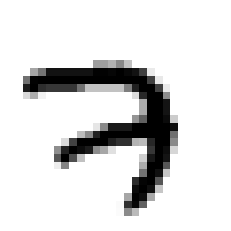

In [112]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9. Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a `class_names` array:

In [113]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [114]:
X_valid.shape

(5000, 28, 28)

In [115]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

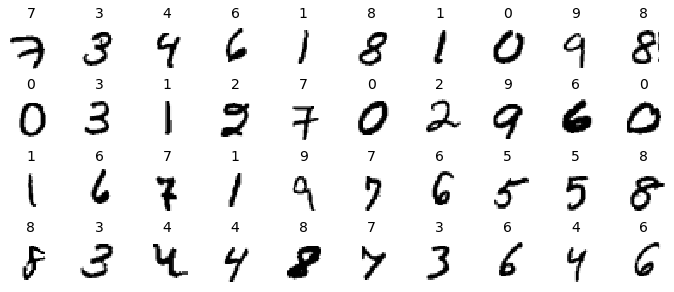

In [116]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [117]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [118]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

We will start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

In [120]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Now let's train the model for just 1 epoch:

In [121]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.5843 - val_loss: nan - val_accuracy: 0.0958


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

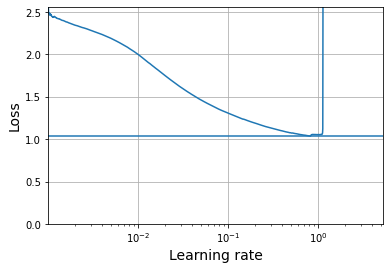

In [122]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

The loss starts shooting back up violently when the learning rate goes over 6e-1, so let's try using half of that, at 3e-1:

In [123]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [124]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [125]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [126]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [127]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2363 - accuracy: 0.9264 - val_loss: 0.0972 - val_accuracy: 0.9720
Epoch 2/100
1719/1719 [==============================] - 2s 997us/step - loss: 0.0948 - accuracy: 0.9702 - val_loss: 0.1035 - val_accuracy: 0.9706
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0667 - accuracy: 0.9792 - val_loss: 0.0783 - val_accuracy: 0.9770
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0463 - accuracy: 0.9848 - val_loss: 0.0827 - val_accuracy: 0.9766
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0359 - accuracy: 0.9881 - val_loss: 0.0698 - val_accuracy: 0.9826
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.1048 - val_accuracy: 0.9758
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0245 - accuracy: 0.9917 - val_loss: 0.0932 - val_

In [128]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 908us/step - loss: 0.0708 - accuracy: 0.9799


[0.07079131156206131, 0.9799000024795532]

We got over 98% accuracy. Finally, let's look at the learning curves using TensorBoard:

In [129]:
%tensorboard --logdir=./my_mnist_logs